In [1]:
### Spark Imports
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

spark = SparkSession.builder.appName('MG').getOrCreate()

In [2]:
### Spark ML Imports
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors

In [3]:
### Pyhton Imports
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
import pandas as pd
from sklearn import preprocessing
from PIL import Image
from collections import Counter

In [4]:
# Display parameters
%pylab inline
pylab.rcParams['figure.figsize'] = (24, 16)

Populating the interactive namespace from numpy and matplotlib


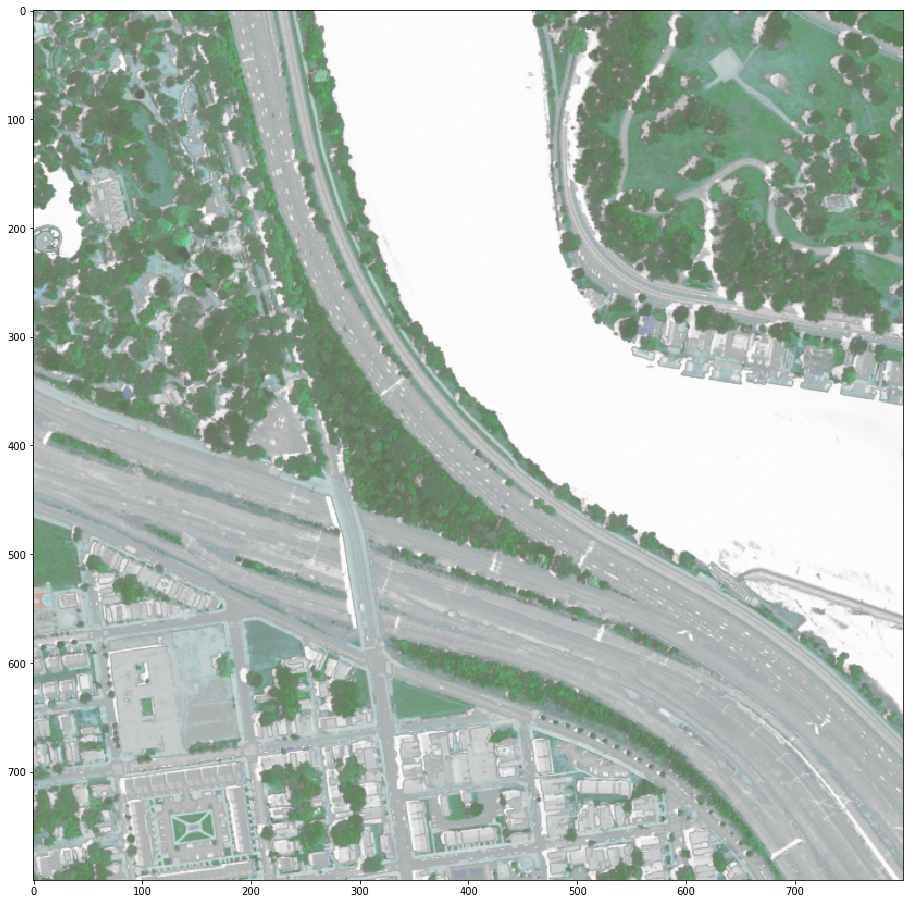

In [5]:
# Read image
fileName = "NAIP_minis/4800_3200.tif"
image = Image.open(fileName)
imageW = image.size[0]
imageH = image.size[1]

# Number of clusters, one for green, one for non-green
K = 2

plt.imshow(image)

In [6]:
# Initialise dataVector with attribute r,g,b,nir,x,y for each pixel
dataVector = np.ndarray(shape=(imageW * imageH, 6), dtype=float)

# Populate data vector with data from input image
# dataVector has 6 fields: red, green, blue, NIR, x coord, y coord
for y in range(0, imageH):
    for x in range(0, imageW):
        xy = (x, y)
        rgb = image.getpixel(xy)
        dataVector[x + y * imageW, 0] = rgb[0]
        dataVector[x + y * imageW, 1] = rgb[1]
        dataVector[x + y * imageW, 2] = rgb[2]
        dataVector[x + y * imageW, 3] = rgb[3]
        dataVector[x + y * imageW, 4] = x
        dataVector[x + y * imageW, 5] = y

In [7]:
# NDVI calculation
num = (dataVector[:, 3]-dataVector[:, 0])
den = (dataVector[:, 3]+dataVector[:, 0])
ndvi_array = num / den

In [8]:
# Convert Numpy array to Pandas Dataframe
temp_df = pd.DataFrame(ndvi_array, columns=list('N'))
temp_df = temp_df.fillna(0)

In [9]:
# Generate feature vector from Spark Dataframe
df = spark.createDataFrame(temp_df)
vecAssembler = VectorAssembler(inputCols=["N"], outputCol="features")
new_df = vecAssembler.transform(df)

In [10]:
# Clustering into k clusters
kmeans = KMeans(k=K, seed=1)
model = kmeans.fit(new_df.select('features'))
transformed = model.transform(new_df)

In [11]:
# Extract the cluster IDs for each pixel
pixelClusterAppartenance = np.array(transformed.select('prediction').collect())
pixelClusterAppartenance.shape

(640000, 1)

In [12]:
# Assign colour based on most frequent clusterID
idx = Counter(list(pixelClusterAppartenance.flatten()))
idx = idx.most_common()
idx = [idx[i][0] for i in range(len(idx))]
idx = np.array(idx)

In [13]:
clr_lst = ['00FF00', '0000FF', 'FF8C00', 'FF1493', 'FFFFE0', '4B0082']
clr_lst = clr_lst[:K]

In [14]:
# Convert hex color representations to RGB values
colors = []
for index in range(K):
    rgb = list(int(clr_lst[index][i:i+2], 16) for i in (0, 2 ,4))
    colors.append(rgb)
    
color = np.array(colors)

In [15]:
# Convert list of arrays to matrix
for index, item in enumerate(pixelClusterAppartenance):
    dataVector[index][0] = int(color[int(np.where(idx==item)[0][0]), 0])
    dataVector[index][1] = int(color[int(np.where(idx==item)[0][0]), 1])
    dataVector[index][2] = int(color[int(np.where(idx==item)[0][0]), 2])

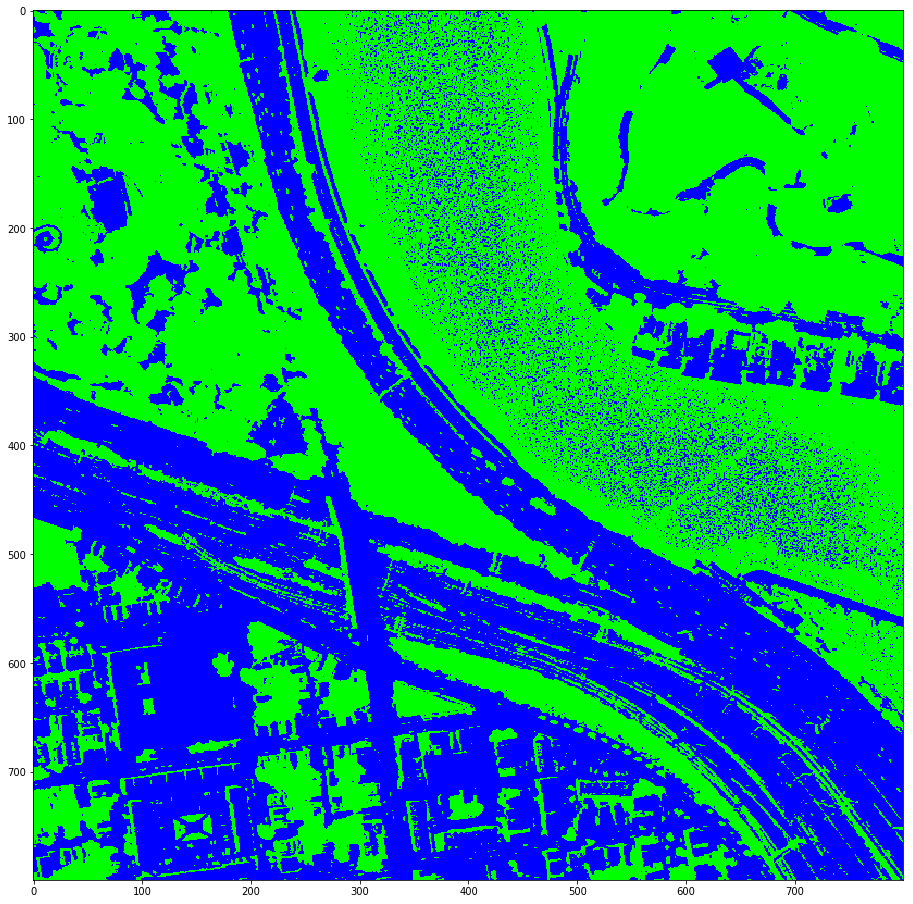

In [16]:
# Fill clusters
image = Image.new("RGB", (imageW, imageH))

for y in range(imageH):
    for x in range(imageW):
        image.putpixel((x, y), (int(dataVector[y * imageW + x][0]), 
                                int(dataVector[y * imageW + x][1]),
                                int(dataVector[y * imageW + x][2])))

# Display image mask
plt.imshow(image)